# **Spotify playlist clustering**

Clustering - grouping of objects based on similarities between them.

In this work, the Spotify playlist will be clustered using the k-means algorithm. Let's import the data that was obtained from Spotipy session (songs_info.csv and audio_features.csv).




### **Preprocessing**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving audio_features.csv to audio_features.csv
Saving clustering_functions.py to clustering_functions.py
Saving songs_info.csv to songs_info.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import clustering_functions as cl

In [4]:
# loading the data
df_features = pd.read_csv('audio_features.csv').iloc[:, 1:]
df_info = pd.read_csv('songs_info.csv').iloc[:, 1:]

df_features = df_features.rename(columns={'uri': 'id'})

# Replace substring
df_features = df_features.replace('spotify:track:', '', regex=True)

**Spotipy audio features:**
*   acousticness - probability on a scale 0 to 1 whether the track is acoustic
*   danceability - describes how suitable the track is for dancing based on few parameters
*   duration_ms - duration of track in miliseconds
*   energy - measure of intensity and activity that give positive energy
*   instrumentalness - 0 - a lot of vocals, 1 - no vocals, track is instrumental
*   key - the key of the track using Pitch Class Notation (values 0-11, if no key detected - value of -1)
*   liveness - detects the presence of an audience in a recording (likelihood on a scale 0-1 whether the song was performed live)
*   loudness - loudness in decibels
*   mode - is the song major (1) or minor (0)
*   speechiness - presence of spoken words in a track (0 - no words, 1 song made entirely of words)
*   tempo - tempo in beats per minute
*   time_signature - how many beats are in each bar -  measure (3/4 or 7/4 measures)
*   valence - a measure from 0 to 1 describing musical possitiveness of a track

In [5]:
df_features.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,id
0,0.238,0.109,81.264,0.0326,0.04210,0.000027,3,0.289,0,282493,-12.244,0.187,1,audio_features,4MpIwDaZdFLafMDcAx4k4q
1,0.573,0.145,84.967,0.4330,0.36100,0.000000,4,0.744,7,275294,-8.068,0.398,0,audio_features,2unYQbgst3vkYdAxH1rbEp
2,0.734,0.220,120.550,0.0374,0.00079,0.005540,4,0.461,1,357933,-9.379,0.423,1,audio_features,6F6DxQ3XjToEHX1e2KKSbg
3,0.551,0.127,118.657,0.0331,0.00606,0.000256,4,0.491,8,259867,-9.652,0.349,0,audio_features,2L6LeWFHYhcxisYJ9X0Adn
4,0.666,0.204,130.915,0.1290,0.05280,0.001710,4,0.769,0,253533,-8.218,0.558,1,audio_features,0eZO12gIzIJ1HnV59OvYGT


In the table describing the features we can see both categorical and continuous data. In order to use the data for clustering, the categorical values should be converted to binaries. The necessary operation will be done to 'time_signature', 'key' and 'mode' columns.
We can also get rid of features like 'type' and 'id' which are only meta data.

In [6]:
# get binary values for categorical data
for col in ['time_signature', 'key', 'mode']:
    dummies = pd.get_dummies(df_features[col], prefix=col)
    df_features = pd.concat([df_features, dummies], axis=1)
    df_features.drop(col, axis=1, inplace=True)

# choose only columns with relevant features
df_features = df_features.drop(['type', 'id'], axis=1)
df_features.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,0.238,0.109,81.264,0.0326,0.04210,0.000027,0.289,282493,-12.244,0.187,...,0,0,0,0,0,0,0,0,0,1
1,0.573,0.145,84.967,0.4330,0.36100,0.000000,0.744,275294,-8.068,0.398,...,0,0,0,1,0,0,0,0,1,0
2,0.734,0.220,120.550,0.0374,0.00079,0.005540,0.461,357933,-9.379,0.423,...,0,0,0,0,0,0,0,0,0,1
3,0.551,0.127,118.657,0.0331,0.00606,0.000256,0.491,259867,-9.652,0.349,...,0,0,0,0,1,0,0,0,1,0
4,0.666,0.204,130.915,0.1290,0.05280,0.001710,0.769,253533,-8.218,0.558,...,0,0,0,0,0,0,0,0,0,1


In [7]:
df1= df_features.iloc[:, :10]
df1.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.640658,0.185750,118.868592,0.141903,0.288443,0.030059,0.603868,255560.983923,-7.958334,0.451511
std,0.177581,0.147245,28.552862,0.134902,0.252545,0.119743,0.160771,80433.972745,3.114011,0.214320
min,0.007560,0.046300,64.210000,0.023300,0.000022,0.000000,0.193000,125093.000000,-28.353000,0.046100
25%,0.534500,0.098300,94.161500,0.035650,0.062000,0.000000,0.496500,201429.000000,-9.179000,0.274500
50%,0.657000,0.128000,119.911000,0.072500,0.231000,0.000002,0.629000,237456.000000,-7.284000,0.446000
75%,0.765000,0.220000,136.559500,0.236000,0.454000,0.000573,0.739500,284612.500000,-6.148500,0.593000
max,0.988000,0.988000,189.880000,0.679000,0.941000,0.835000,0.919000,735000.000000,-2.135000,0.931000


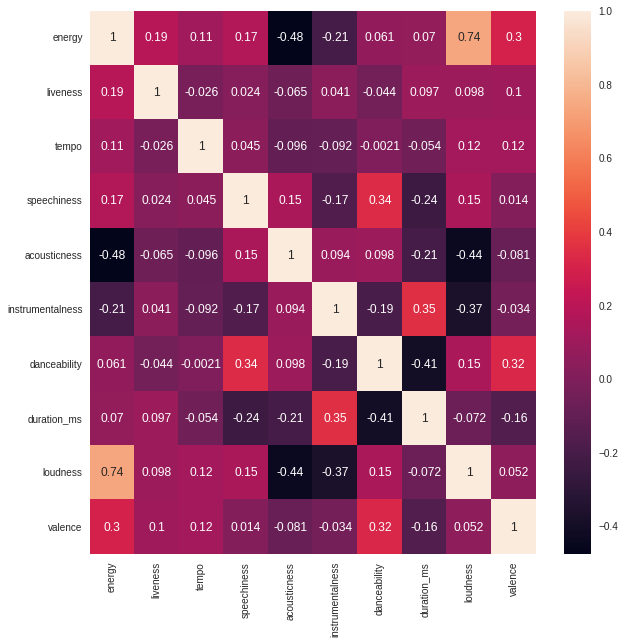

In [8]:
# Pearson correlation matrix
plt.figure(figsize=(10,10))
corr = df1.corr()
sns.heatmap(corr, annot = True)
plt.show()

From the Pearson corellation matrix: there is a visible positive correlation between energy and loudness. Also, instrumentalness and acousticness correlate negatively with loudness.
Therefore, loud songs are usually more energetic, and don't contain a lot of instrumental and acoustic fragments.

### **K-means clustering**

##### **Elbow Method** 

Elbow Method helps set the k parameter for k-means clustering.

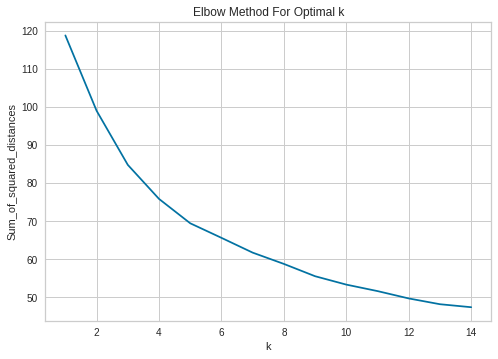

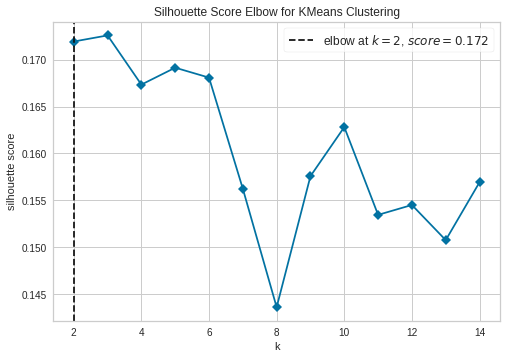

In [9]:
score,value,df1_scaled = cl.elbow_method(df1)

##### **Clustering**
From the Elbow Method it can be seen that the highest score was achieved for 3 clusters, therefore k will be set to 3.

In [10]:
k=3
df_features,df_info=cl.kmeans_clustering(df1_scaled, k, df_features, df_info)

In [11]:
# save metadata of clusters
km1_0 = df_info[df_info['kmeans-3clusters']==0]
km1_1 = df_info[df_info['kmeans-3clusters']==1]
km1_2 = df_info[df_info['kmeans-3clusters']==2]

# save features of clusters
f1_0 = df_features[df_features['kmeans-3clusters']==0]
f1_1 = df_features[df_features['kmeans-3clusters']==1]
f1_2 = df_features[df_features['kmeans-3clusters']==2]

In [12]:
# save data to csv
km1_0.to_csv('km1-cluster0.csv')
km1_1.to_csv('km1-cluster1.csv')
km1_2.to_csv('km1-cluster2.csv')

f1_0.to_csv('features1-cluster0.csv')
f1_1.to_csv('features1-cluster1.csv')
f1_2.to_csv('features1-cluster2.csv')

### **Analysis of the results**
The lists cotaining the songs in each cluster show that they have been divided into:
*   cluster 0 - calm songs
*   cluster 1 - rap songs
*   cluster 2 - rock songs

##### **Features distribution**

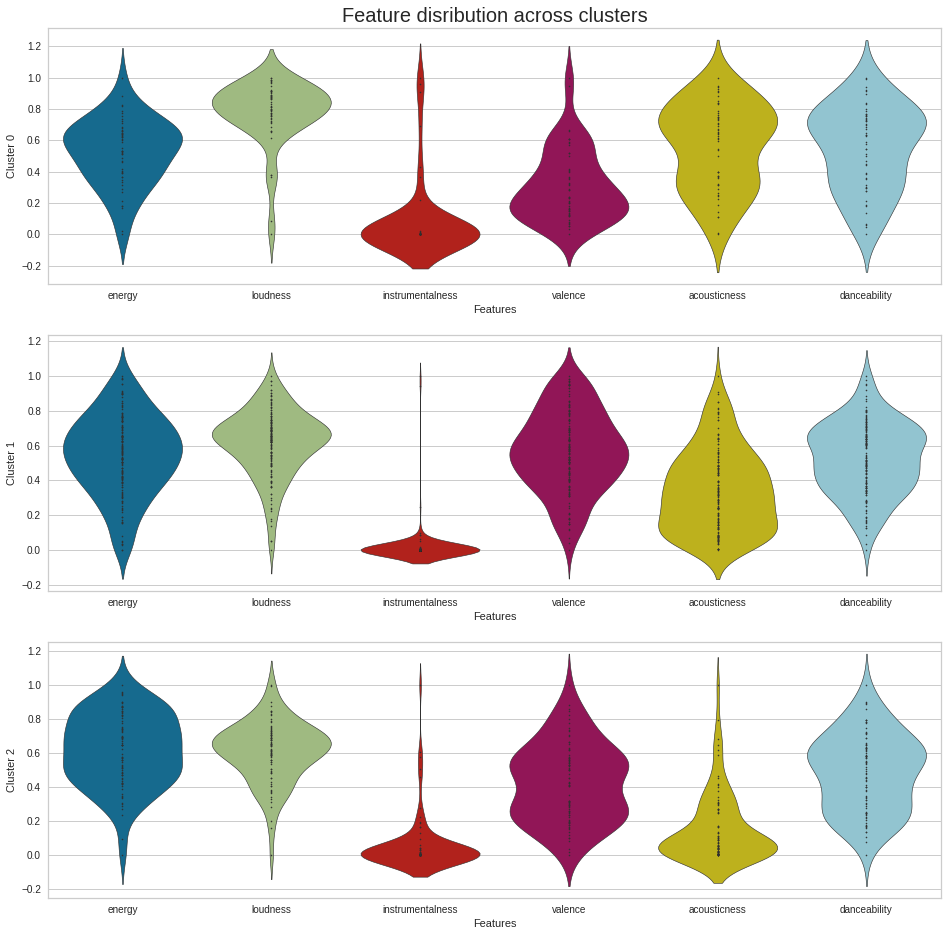

In [13]:
# feature distribution visualisation across 3 clusters
c0 = f1_0
c1 = f1_1
c2 = f1_2

c0 = c0.loc[:,['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability"]]
c1 = c1.loc[:,['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability"]]
c2 = c2.loc[:,['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability"]]

x = c0.values #returns a numpy array
min_max_scaler = MinMaxScaler()
c0_scaled = min_max_scaler.fit_transform(x)
c0 = pd.DataFrame(c0_scaled)
c0.columns = ['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability" ]
c0=c0.melt(var_name='Features', value_name='Cluster 0')

x = c1.values #returns a numpy array
min_max_scaler = MinMaxScaler()
c1_scaled = min_max_scaler.fit_transform(x)
c1 = pd.DataFrame(c1_scaled)
c1.columns = ['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability" ]
c1=c1.melt(var_name='Features', value_name='Cluster 1')

x = c2.values #returns a numpy array
min_max_scaler = MinMaxScaler()
c2_scaled = min_max_scaler.fit_transform(x)
c2 = pd.DataFrame(c2_scaled)
c2.columns = ['energy', 'loudness', 'instrumentalness', "valence", "acousticness", "danceability"]
c2=c2.melt(var_name='Features', value_name='Cluster 2')


f, axes = plt.subplots(3, 1, figsize=(16,16))
ax = sns.violinplot( data=c0 ,x="Features", y="Cluster 0", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[0])
ax.set_title("Feature disribution across clusters", fontsize=20)
ax = sns.violinplot( data=c1 ,x="Features", y="Cluster 1", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[1])
ax = sns.violinplot( data=c2 ,x="Features", y="Cluster 2", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[2])
plt.show()

It is clearly visible that these features differ in each clusters. The most acoustic songs are gouped in cluster 0, the least instrumental songs are grouped in cluster 1, and valence (positiveness) is displayed more by rap and rock songs than the balladic ones.

##### **Visualisation of the clusters**
Let's see how the division of the clusters looks like on a 3d scatter plot.

In [14]:
fig1 = px.scatter_3d(df_features, x='acousticness', y='loudness', z='valence',
              color=df_features['kmeans-3clusters'],
              labels={"kmeans-3clusters": "Clusters"},
              title='Cluster division',
              )
fig1.show()

As we can see, the clusters of rock and rap songs are a mixed a bit - this may happen as both groups can be loud and have a stronger sound.

At the same time, the calm songs form a separate group - with only few elements mixing with the other categories (these items are mostly rock and rap songs that have a more balladic sound). 

Let's check the names of the songs that are outliers or get to mix with other categories.

In [15]:
fig2 = px.scatter_3d(f1_0, x='acousticness', y='loudness', z='valence',
              color=km1_0['kmeans-3clusters'], text=km1_0['name'],
              labels={
                     "color": "Cluster-label"
                 },
                title="Cluster 0 - calm songs")
fig2.show()

In [16]:
fig3 = px.scatter_3d(f1_1, x='acousticness', y='loudness', z='valence',
                     color=km1_1['kmeans-3clusters'], text=km1_1['name'],
                     labels={
                     "color": "Cluster-label"
                 },
                title="Cluster 1 - rap songs")
fig3.show()

In [17]:
fig4 = px.scatter_3d(f1_2, x='acousticness', y='loudness', z='valence',
              color=km1_2['kmeans-3clusters'], text=km1_2['name'],
              labels={
                     "color": "Cluster-label"
                  },
                title="Cluster 2 - rock songs")
fig4.show()

### **Summary**
The user's playlist have been clustered into 3 groups - calm, rap an rock songs. Since the content od the original playlist is quite mixed, the clusters contain many outliers as well as elements that could also belong to other groups. For more precise clustering a larger k number could be picked. However, this could also result in even more mixed results - the features provided by the method used in obtaining the data do not differentiate that well between so many genres. 

This solution could be used to observe the characteristics of the music you listen to. Moreover, it could be a very useful tool for creating smaller playlists - suitable for different moods. 